### Processes images generated from Minecraft screen captures into an HDF5 dataset file

#### Current dataset format

Screenshots are created by teleporting to 3 different world locations:
- **farm**: (-50, 64, 410)
- **forest**: (-273, 65, 782)
- **home**: (-105, 63, 59)

At each location, the pitch is varied to cause the bot to rotate slowly in a circle, and the yaw is chosen randomly at each time step from the interval (-0.20, 0.20) in radians.

The dataset file that is produced by this notebook is in HDF5 format and contains a total of **3600** images. There are **1200** images from each location, and the images are grouped by location in the following order: **farm, forest, home**. Inside each group, the images are shuffled to remove temporal correlations. Each image is a matrix of shape **(1050, 1680, 3)**.

In [1]:
from scipy import ndimage
from scipy.misc import imresize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Example: loading a PNG image

In [2]:
file = "/Users/cosmo/Documents/workspace/screenshot/farm/7.png"
image = ndimage.imread(file)

Check the dimension of the screenshots:

In [3]:
image.shape

(1050, 1680, 3)

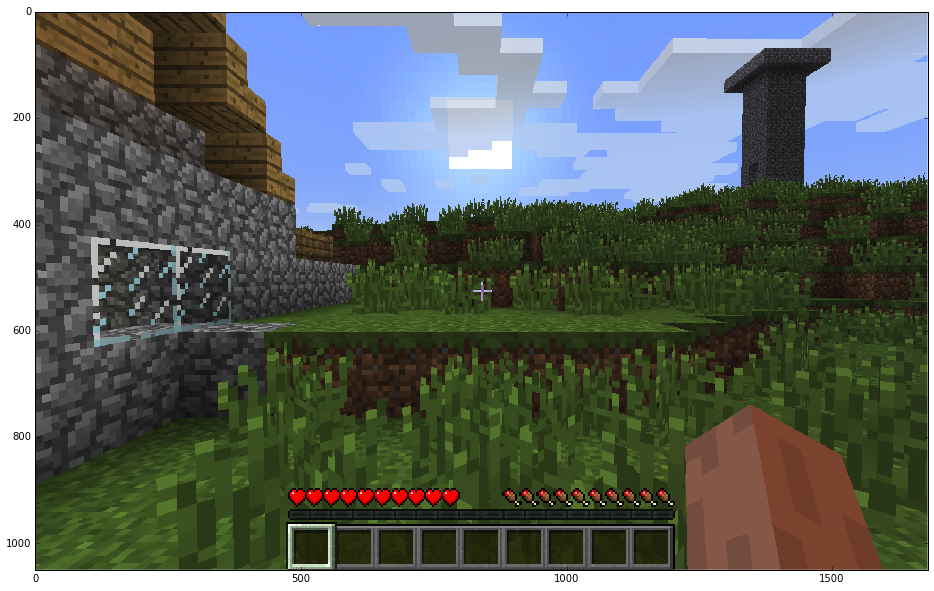

In [4]:
plt.figure(figsize = (16, 10))
plt.imshow(image, interpolation='none');

### Load all of the image files from the screen captures generated in different world regions

In [5]:
import glob

In [6]:
farm_files = glob.glob('/Users/cosmo/Documents/workspace/screenshot/farm/*.png')
forest_files = glob.glob('/Users/cosmo/Documents/workspace/screenshot/forest/*.png')
home_files = glob.glob('/Users/cosmo/Documents/workspace/screenshot/home/*.png')

#### Shuffle the order of the images to remove the temporal correlation

In [7]:
np.random.shuffle(farm_files)
np.random.shuffle(forest_files)
np.random.shuffle(home_files)

#### Also create a small test list for development purposes

In [8]:
test_files = farm_files[:20]

#### Downsampling the images is possible:

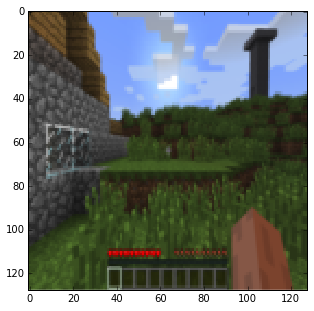

In [9]:
h_scale = 10
v_scale = 10
plt.figure(figsize = (8, 5));
# plt.imshow(imresize(image, (int(1050 / h_scale), int(1680 / v_scale))));
plt.imshow(imresize(image, (128, 128)), interpolation='none');

If we don't downsample, we have $1680*1050=1764000$ pixels per image. If we downsample by a factor of 5, then we have $336*210=70560$ pixels per image. If we downsample to (128, 128) images then we have 16384 pixels per image.

## Create the HDF5 dataset

In [10]:
import h5py
from fuel.datasets.hdf5 import H5PYDataset

In [11]:
f = h5py.File('dataset.hdf5', mode='w')

In [12]:
num_images = 1200 * 3
height = 1050
width = 1680
# height = 128
# width = 128
colors = 3

In [13]:
vector_images = f.create_dataset('vector_images', (num_images, height, width, colors), dtype='uint8')

In [23]:
type(vector_images)

h5py._hl.dataset.Dataset

#### Load the images into the dataset

Since we have a large number of images to add to the dataset, we divide the work into batches, and flush to disk every 100 images.

In [14]:
# We can optionally downsample the images before adding them to the dataset
downsample = False
# If subsample is True, then we need to define the image size here
image_size = (height, width)

# How many images to add to the dataset in each batch before flushing to disk
batch_size = 100

# List of classes that will be added to the dataset
classes = [farm_files, forest_files, home_files]
class_names = ['farm', 'forest', 'home']
images_per_class = 1200

# Calculate how many batches will be needed per class
batches_per_class = int(images_per_class / batch_size)

# For each image class
for class_idx in range(len(classes)):
    print('Processing class: {0}'.format(class_names[class_idx]))

    # Split this class into batches_per_class batches
    for batch in range(batches_per_class):
        # Compute the offset based on what batch number we are on in order
        # to add the offset to the image index in the vector of images
        offset = batch * batch_size
        for i in range(batch_size):
            image = ndimage.imread(classes[class_idx][offset + i])
            image_index = class_idx * images_per_class + offset + i
            
            if downsample:
                vector_images[image_index] = imresize(image, image_size)
            else:
                # This is where the image gets added to the HDF5 dataset:
                vector_images[image_index] = image
                
        # Write the dataset that has been constructed so far to disk
        f.flush()
        print('Batch #{0}/{1} done.'.format(batch + 1, batches_per_class))

Processing class farm.
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.
Processing class forest.
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.
Processing class home.
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.


#### Multiple datasets can be combined by using splits. In this case we only use 1.

In [15]:
split_dict = {
    'train': {'vector_images': (0, 4)},
}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [16]:
f.flush()
f.close()

### Access the HDF5 dataset we created

In [17]:
from fuel.datasets.hdf5 import H5PYDataset

In [18]:
dataset = H5PYDataset('dataset.hdf5', which_sets=('train',))

In [19]:
handle = dataset.open()

#### Load a small slice from each subset of the data and look at the resulting images

In [20]:
offset = 1200
farm_data_slice,   = dataset.get_data(handle, slice(0, 5))
forest_data_slice, = dataset.get_data(handle, slice(1 * offset + 1, 1 * offset + 1 + 5))
home_data_slice,   = dataset.get_data(handle, slice(2 * offset + 1, 2 * offset + 1 + 5))

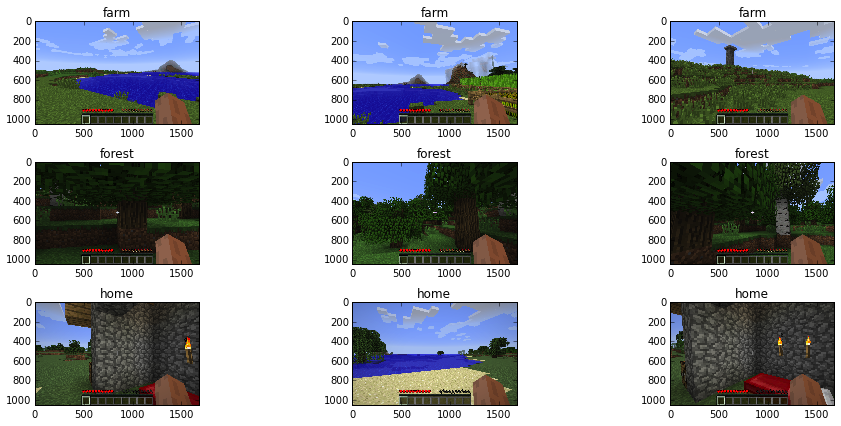

In [21]:
fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k');
data_sources = [farm_data_slice, forest_data_slice, home_data_slice]
titles = ['farm', 'forest', 'home']
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3,3,i*3+j+1);
        ax.imshow(data_sources[i][j]);
        ax.set_title(titles[i]);
fig.tight_layout();

In [22]:
dataset.close(handle)